Author: Lucas Lopes\
E-mail: lucas.arlop@gmail.com

# Desafio Cientista de Dados

A Lumia quer expandir seus negócios e para isso precisa automatizar o processo decisório
de crédito, que até então vinha sendo feito de forma manual pelo seu time de analistas de
crédito. Para isso, solicitou a você, cientista de dados, a análise da base dos créditos
concedidos aos seus clientes no ano de 2020. O objetivo é, que a cada nova proposta de
crédito, na sua plataforma digital, a aprovação (para bons clientes) ou recusa (para os maus
clientes) seja decidida em poucos segundos.


- https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

a. Apresente seu roteiro de análise passo a passo;\
b. Execute seu roteiro, utilizando Python;\
c. Faça um resumo dos resultados, conclusões e recomendações a partir da sua
análise;\
d. Quais os próximos passos que você sugere para atingir o objetivo inicial de
automatizar o processo decisório e escalar a operação?\
e. Você tem sugestões para melhorar o resultado obtido?

Instruções
   1. Use o data set german.data que foi enviado atráves do link
   2. Desconsidere a matriz de custo na solução do problem
   
Entrega:\
A entrega deve ser realizada via repositório público no github contendo:
- jupyter notebook com a análise e modelagem
- modelo salvo
---

## Respostas

**a, b**. Segue o roteiro de análise realizado com alguns comentários breves durante o decorrer do _notebook_.

**c**. O resumo dos resultados, conclusões e recomendações seguem ao longo do roteiro enfatizando os principais pontos.

**d, e**. São apresentados por último, após o acompanhamento de toda a análise.

---

# Configuração de Ambiente

## Versões Utilizadas
Python    : 3.8.5\
sklearn   : 0.23.2\
numpy     : 1.19.5\
imblearn  : 0.8.0\
pandas    : 1.2.5\
json      : 2.0.9\
autokeras : 1.0.15\
matplotlib: 3.1.3\
tensorflow: 2.5.0\
seaborn   : 0.11.0

In [1]:
import os
import json
import pandas     as pd
import numpy      as np
import tensorflow as tf
import autokeras  as ak

from tensorflow              import keras
from tensorflow.keras        import layers
from tensorflow.keras.models import load_model

from imblearn                import under_sampling, over_sampling
from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import sklearn
from sklearn                 import model_selection
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn                 import preprocessing
from sklearn.preprocessing   import LabelEncoder
from sklearn.preprocessing   import OneHotEncoder

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn           as sns

%matplotlib inline

# Base de Dados: [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                 names=[x for x in range(1, 22)],
                 header=None,
                 delim_whitespace=True,
                 index_col=False)

df = df.add_prefix('attr_')
df.columns = [*df.columns[:-1], 'Class']
df['Class'] = df['Class'].map({1: 1, 2: 0})
df

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_12,attr_13,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,Class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,0


## Classificação Desbalanceada

In [3]:
df['Class'].value_counts()

1    700
0    300
Name: Class, dtype: int64

# Análise dos Dados

In [4]:
df.dtypes

attr_1     object
attr_2      int64
attr_3     object
attr_4     object
attr_5      int64
attr_6     object
attr_7     object
attr_8      int64
attr_9     object
attr_10    object
attr_11     int64
attr_12    object
attr_13     int64
attr_14    object
attr_15    object
attr_16     int64
attr_17    object
attr_18     int64
attr_19    object
attr_20    object
Class       int64
dtype: object

## Estatística

In [5]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,attr_2,attr_5,attr_8,attr_11,attr_13,attr_16,attr_18,Class
count,"1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00"
mean,20.90,"3,271.26",2.97,2.85,35.55,1.41,1.16,0.70
std,12.06,"2,822.74",1.12,1.10,11.38,0.58,0.36,0.46
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00,0.00
25%,12.00,"1,365.50",2.00,2.00,27.00,1.00,1.00,0.00
50%,18.00,"2,319.50",3.00,3.00,33.00,1.00,1.00,1.00
75%,24.00,"3,972.25",4.00,4.00,42.00,2.00,1.00,1.00
max,72.00,"18,424.00",4.00,4.00,75.00,4.00,2.00,1.00


## Matriz de Correlação

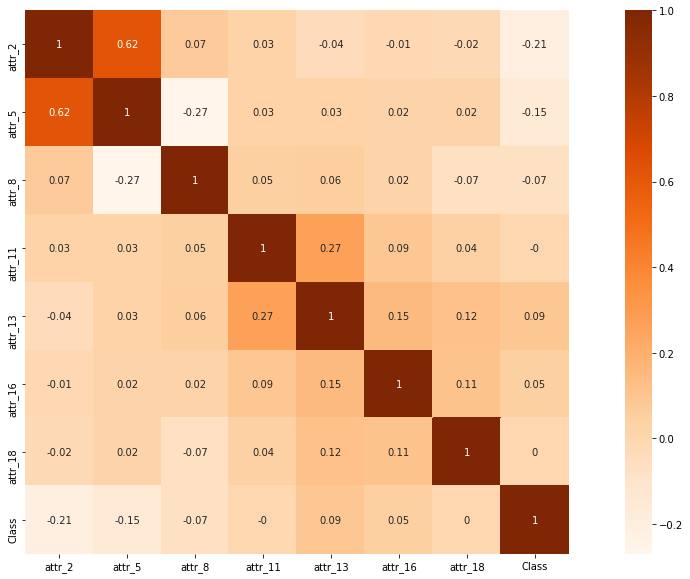

In [6]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize = (20,10))
sns.heatmap(data = correlation_matrix, square = True, annot = True, cmap = 'Oranges')

## Checagem de Valores Nulos

In [7]:
df.isnull().any()

attr_1     False
attr_2     False
attr_3     False
attr_4     False
attr_5     False
attr_6     False
attr_7     False
attr_8     False
attr_9     False
attr_10    False
attr_11    False
attr_12    False
attr_13    False
attr_14    False
attr_15    False
attr_16    False
attr_17    False
attr_18    False
attr_19    False
attr_20    False
Class      False
dtype: bool

# Pré-processamento de Dados

O processamento de dados se dará de diferentes formas para alguns dos atributos, agrupados como a seguir.

In [8]:
numerical_features = ['attr_2', 'attr_5', 'attr_8', 'attr_11', 'attr_13', 'attr_16', 'attr_18']
personal_features  = ['attr_7', 'attr_9']
le_features        = ['attr_19', 'attr_20']
ohe_features       = ['attr_1', 'attr_3', 'attr_4', 'attr_6', 'attr_10', 'attr_12', 'attr_14', 'attr_15', 'attr_17']

## Tratamento Personalizado

Os seguintes atributos foram selecionados para uma melhor avaliação pelos seguintes motivos:

- Attribute 7: (Present employment since) possui 4 categorias nas quais pode existir uma relação númerica.
<!-- A71 : unemployed
A72 : ... < 1 year
A73 : 1 <= ... < 4 years
A74 : 4 <= ... < 7 years
A75 : .. >= 7 years
 -->
 
- Attribute 9: (Personal status and sex) possui 4 categorias que podem ser dividida em outros 2 atributos: sexo e estado civil.
<!-- A91 : male : divorced/separated
A92 : female : divorced/separated/married
A93 : male : single
A94 : male : married/widowed
A95 : female : single -->

In [9]:
processed_data = df.copy()
processed_data

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_12,attr_13,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,Class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,0


In [10]:
processed_data['attr_7'] = processed_data['attr_7'].map({'A71': 0, 'A72': 1, 'A73': 4, 'A74': 7, 'A75': 15})
processed_data['attr_9_sex']    = processed_data['attr_9'].map({'A91': 1, 'A92': 2, 'A93': 1, 'A94': 1, 'A95': 2})
processed_data['attr_9_status'] = processed_data['attr_9'].map({'A91': 1, 'A92': 1, 'A93': 2, 'A94': 3, 'A95': 2})
processed_data.pop('attr_9')
processed_data['Class'] = processed_data.pop("Class")
processed_data

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_10,attr_11,...,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,attr_9_sex,attr_9_status,Class
0,A11,6,A34,A43,1169,A65,15,4,A101,4,...,A143,A152,2,A173,1,A192,A201,1,2,1
1,A12,48,A32,A43,5951,A61,4,2,A101,2,...,A143,A152,1,A173,1,A191,A201,2,1,0
2,A14,12,A34,A46,2096,A61,7,2,A101,3,...,A143,A152,1,A172,2,A191,A201,1,2,1
3,A11,42,A32,A42,7882,A61,7,2,A103,4,...,A143,A153,1,A173,2,A191,A201,1,2,1
4,A11,24,A33,A40,4870,A61,4,3,A101,4,...,A143,A153,2,A173,2,A191,A201,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,7,3,A101,4,...,A143,A152,1,A172,1,A191,A201,2,1,1
996,A11,30,A32,A41,3857,A61,4,4,A101,4,...,A143,A152,1,A174,1,A192,A201,1,1,1
997,A14,12,A32,A43,804,A61,15,4,A101,4,...,A143,A152,1,A173,1,A191,A201,1,2,1
998,A11,45,A32,A43,1845,A61,4,4,A101,4,...,A143,A153,1,A173,1,A192,A201,1,2,0


## _Label Encoding_

- Attribute 19 (Telephone)
<!-- A191 : none
A192 : yes, registered under the customers name -->

- Attribute 20 (foreign worker)
<!-- A201 : yes
A202 : no -->

In [11]:
processed_data

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_10,attr_11,...,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,attr_9_sex,attr_9_status,Class
0,A11,6,A34,A43,1169,A65,15,4,A101,4,...,A143,A152,2,A173,1,A192,A201,1,2,1
1,A12,48,A32,A43,5951,A61,4,2,A101,2,...,A143,A152,1,A173,1,A191,A201,2,1,0
2,A14,12,A34,A46,2096,A61,7,2,A101,3,...,A143,A152,1,A172,2,A191,A201,1,2,1
3,A11,42,A32,A42,7882,A61,7,2,A103,4,...,A143,A153,1,A173,2,A191,A201,1,2,1
4,A11,24,A33,A40,4870,A61,4,3,A101,4,...,A143,A153,2,A173,2,A191,A201,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,7,3,A101,4,...,A143,A152,1,A172,1,A191,A201,2,1,1
996,A11,30,A32,A41,3857,A61,4,4,A101,4,...,A143,A152,1,A174,1,A192,A201,1,1,1
997,A14,12,A32,A43,804,A61,15,4,A101,4,...,A143,A152,1,A173,1,A191,A201,1,2,1
998,A11,45,A32,A43,1845,A61,4,4,A101,4,...,A143,A153,1,A173,1,A192,A201,1,2,0


In [12]:
label_encoder = LabelEncoder()
processed_data['attr_20'] = processed_data['attr_20'].apply(lambda x: ['A202', 'A201'].index(x))
for cf in le_features:
    processed_data[cf] = label_encoder.fit_transform(processed_data[cf])
processed_data

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_10,attr_11,...,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,attr_9_sex,attr_9_status,Class
0,A11,6,A34,A43,1169,A65,15,4,A101,4,...,A143,A152,2,A173,1,1,1,1,2,1
1,A12,48,A32,A43,5951,A61,4,2,A101,2,...,A143,A152,1,A173,1,0,1,2,1,0
2,A14,12,A34,A46,2096,A61,7,2,A101,3,...,A143,A152,1,A172,2,0,1,1,2,1
3,A11,42,A32,A42,7882,A61,7,2,A103,4,...,A143,A153,1,A173,2,0,1,1,2,1
4,A11,24,A33,A40,4870,A61,4,3,A101,4,...,A143,A153,2,A173,2,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,7,3,A101,4,...,A143,A152,1,A172,1,0,1,2,1,1
996,A11,30,A32,A41,3857,A61,4,4,A101,4,...,A143,A152,1,A174,1,1,1,1,1,1
997,A14,12,A32,A43,804,A61,15,4,A101,4,...,A143,A152,1,A173,1,0,1,1,2,1
998,A11,45,A32,A43,1845,A61,4,4,A101,4,...,A143,A153,1,A173,1,1,1,1,2,0


## _One Hot Encoding_

In [13]:
processed_data

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_10,attr_11,...,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,attr_9_sex,attr_9_status,Class
0,A11,6,A34,A43,1169,A65,15,4,A101,4,...,A143,A152,2,A173,1,1,1,1,2,1
1,A12,48,A32,A43,5951,A61,4,2,A101,2,...,A143,A152,1,A173,1,0,1,2,1,0
2,A14,12,A34,A46,2096,A61,7,2,A101,3,...,A143,A152,1,A172,2,0,1,1,2,1
3,A11,42,A32,A42,7882,A61,7,2,A103,4,...,A143,A153,1,A173,2,0,1,1,2,1
4,A11,24,A33,A40,4870,A61,4,3,A101,4,...,A143,A153,2,A173,2,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,7,3,A101,4,...,A143,A152,1,A172,1,0,1,2,1,1
996,A11,30,A32,A41,3857,A61,4,4,A101,4,...,A143,A152,1,A174,1,1,1,1,1,1
997,A14,12,A32,A43,804,A61,15,4,A101,4,...,A143,A152,1,A173,1,0,1,1,2,1
998,A11,45,A32,A43,1845,A61,4,4,A101,4,...,A143,A153,1,A173,1,1,1,1,2,0


In [14]:
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
for cf in ohe_features:
    enc_df = pd.DataFrame(ohe_encoder.fit_transform(processed_data[[cf]]).toarray())
    enc_df = enc_df.add_prefix(cf + '-')
    processed_data = processed_data.join(enc_df)
    processed_data.pop(cf)
    
processed_data['Class'] = processed_data.pop("Class")
processed_data

,attr_2,attr_5,attr_7,attr_8,attr_11,attr_13,attr_16,attr_18,attr_19,attr_20,...,attr_14-1,attr_14-2,attr_15-0,attr_15-1,attr_15-2,attr_17-0,attr_17-1,attr_17-2,attr_17-3,Class
0,6,1169,15,4,4,67,2,1,1,1,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1
1,48,5951,4,2,2,22,1,1,0,1,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0
2,12,2096,7,2,3,49,1,2,0,1,...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1
3,42,7882,7,2,4,45,1,2,0,1,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1
4,24,4870,4,3,4,53,2,2,0,1,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,7,3,4,31,1,1,0,1,...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1
996,30,3857,4,4,4,40,1,1,1,1,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1
997,12,804,15,4,4,38,1,1,0,1,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1
998,45,1845,4,4,4,23,1,1,1,1,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0


## Dados de Treinamento e Teste

In [15]:
data   = processed_data.loc[:, processed_data.columns != 'Class']
target = processed_data.loc[:, processed_data.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

print("Training:")
print("\tAttributes Shape:\t{}".format(X_train.shape))
print("\tClass Shape:\t\t{}".format(y_train.shape))
print("------------------------------------------")
print("Test:")
print("\tAttributes Shape:\t{}".format(X_test.shape))
print("\tClass Shape:\t\t{}".format(y_test.shape))

Training:
	Attributes Shape:	(800, 53)
	Class Shape:		(800, 1)
------------------------------------------
Test:
	Attributes Shape:	(200, 53)
	Class Shape:		(200, 1)


### Classes Desbalanceadas

In [16]:
y_train.value_counts()

Class
1        559
0        241
dtype: int64

In [17]:
sm = SMOTE(sampling_strategy=0.6, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.65)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)
print("Training:")
print("\tAttributes Shape:\t{}".format(X_train.shape))
print("\tClass Shape:\t\t{}".format(y_train.shape))
print("------------------------------------------")
print("Test:")
print("\tAttributes Shape:\t{}".format(X_test.shape))
print("\tClass Shape:\t\t{}".format(y_test.shape))

Training:
	Attributes Shape:	(850, 53)
	Class Shape:		(850, 1)
------------------------------------------
Test:
	Attributes Shape:	(200, 53)
	Class Shape:		(200, 1)


In [18]:
print(y_train.value_counts()[0] / (y_train.value_counts()[0] + y_train.value_counts()[1]))
print(y_train.value_counts()[0])
print(y_train.value_counts())

0.3941176470588235
335
Class
1        515
0        335
dtype: int64


### Normalização

In [19]:
X_train

,attr_2,attr_5,attr_7,attr_8,attr_11,attr_13,attr_16,attr_18,attr_19,attr_20,...,attr_14-0,attr_14-1,attr_14-2,attr_15-0,attr_15-1,attr_15-2,attr_17-0,attr_17-1,attr_17-2,attr_17-3
0,60,6836,15,3,4,63,2,1,1,1,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,21,2319,1,2,1,33,1,1,0,1,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,21,5003,4,1,4,29,2,1,1,1,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,24,1442,7,4,4,23,2,1,0,1,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,24,2359,0,1,1,33,1,1,0,1,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,24,6579,0,4,2,29,1,1,1,1,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
846,24,3868,15,4,2,41,2,1,1,1,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
847,15,1300,15,4,4,45,1,2,0,1,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
848,11,7228,4,1,4,39,2,1,0,1,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
nX_train = pd.DataFrame(data=min_max_scaler.fit_transform(X_train.values), columns=X_train.columns)
nX_train

,attr_2,attr_5,attr_7,attr_8,attr_11,attr_13,attr_16,attr_18,attr_19,attr_20,...,attr_14-0,attr_14-1,attr_14-2,attr_15-0,attr_15-1,attr_15-2,attr_17-0,attr_17-1,attr_17-2,attr_17-3
0,1.00,0.36,1.00,0.67,1.00,0.79,0.33,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.30,0.11,0.07,0.33,0.00,0.25,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,0.30,0.26,0.27,0.00,1.00,0.18,0.33,0.00,1.00,1.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,0.36,0.07,0.47,1.00,1.00,0.07,0.33,0.00,0.00,1.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.36,0.12,0.00,0.00,0.00,0.25,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,0.36,0.35,0.00,1.00,0.33,0.18,0.00,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
846,0.36,0.20,1.00,1.00,0.33,0.39,0.33,0.00,1.00,1.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
847,0.20,0.06,1.00,1.00,1.00,0.46,0.00,1.00,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
848,0.12,0.38,0.27,0.00,1.00,0.36,0.33,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [21]:
nX_test = pd.DataFrame(data=min_max_scaler.fit_transform(X_test.values), columns=X_test.columns)
nX_test

,attr_2,attr_5,attr_7,attr_8,attr_11,attr_13,attr_16,attr_18,attr_19,attr_20,...,attr_14-0,attr_14-1,attr_14-2,attr_15-0,attr_15-1,attr_15-2,attr_17-0,attr_17-1,attr_17-2,attr_17-3
0,0.21,0.20,0.27,0.33,0.33,0.08,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.21,0.28,0.27,0.67,1.00,0.31,0.00,1.00,1.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2,0.29,0.14,0.47,0.33,0.67,0.25,0.00,0.00,0.00,1.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,0.12,0.07,0.27,0.67,1.00,0.06,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.43,0.48,0.47,0.67,0.33,0.31,0.33,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.29,0.20,1.00,0.67,0.33,0.12,0.00,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
196,0.82,0.49,0.07,1.00,0.33,0.08,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
197,0.29,0.43,0.27,0.33,0.33,0.02,0.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
198,0.29,0.23,0.27,0.00,1.00,0.04,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


# Classificadores Gerais

Alguns dos classificadores tradicionais mais conhecidos aplicados ao problema.

In [22]:
classifiers = {
    "SVC": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB(),
    "MLP": MLPClassifier()
}

## Treinamentos Iniciais

In [23]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in classifiers.keys():
    cv_res = model_selection.cross_validate(classifiers[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="accuracy", # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                                             cv=5, n_jobs=-1)
    ncv_res = model_selection.cross_validate(classifiers[key], nX_train, y_train, 
                                             return_train_score=True,
                                             scoring="accuracy", # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score':  cv_res["test_score"].mean(),
        'fit_time':    cv_res["fit_time"].mean(),
        'score_time':  cv_res["score_time"].mean(),
    }
    nres = {
        'model': key + " (normalized)", 
        'train_score': ncv_res["train_score"].mean(), 
        'test_score':  ncv_res["test_score"].mean(),
        'fit_time':    ncv_res["fit_time"].mean(),
        'score_time':  ncv_res["score_time"].mean(),
    }
    cv_results = cv_results.append(res, ignore_index=True)
    cv_results = cv_results.append(nres, ignore_index=True)
    
cv_results.sort_values('test_score', ascending=False)

,model,train_score,test_score,fit_time,score_time
4,RandomForest,1.00,0.77,0.54,0.04
5,RandomForest (normalized),1.00,0.76,0.61,0.04
9,MLP (normalized),0.97,0.75,2.15,0.01
1,SVC (normalized),0.87,0.74,0.31,0.02
6,GaussianNaiveBayes,0.75,0.71,0.01,0.01
3,DecisionTree (normalized),1.00,0.69,0.02,0.01
2,DecisionTree,1.00,0.68,0.02,0.01
7,GaussianNaiveBayes (normalized),0.71,0.67,0.01,0.01
0,SVC,0.63,0.62,0.40,0.03
8,MLP,0.61,0.60,0.34,0.01


Podemos notar que alguns dos algoritmos tiveram _score_ muito alto em treinamento porém com uma queda considerável quando executados para o conjunto de testes. Possivelmente houve _overfitting_. Já as Redes Bayesianas apresentaram um resultado mais aproximado ao obtido durante o treinamento.

**Obs**: os resultados aqui avaliados são médias de 5 execuções em validação cruzada. Portanto, o conjunto de teste aqui referido **não** é o mesmo que iremos utilizar para a avaliação final.\
**Obs 2**: mais à frente, iremos gerar os classificadores com todo o conjunto de treino e então comparar com o real conjunto de testes pré-estabelecido.

# AutoKeras

Neste caso, diferente do anterior, o treinamento já é realizado considerando como avaliação o real conjunto de de testes.

## Condição de Parada

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15)

## Treinamento

In [25]:
# %%time
ak_clf = ak.StructuredDataClassifier(overwrite = True, max_trials = 100, objective="val_accuracy", project_name="ak_classifiers")
ak_clf.fit(x = X_train, y = y_train, validation_data=(X_test, y_test), verbose = 2, callbacks=[callback])

Trial 36 Complete [00h 00m 19s]
val_accuracy: 0.7749999761581421

Best val_accuracy So Far: 0.8100000023841858
Total elapsed time: 00h 09m 43s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./ak_classifiers/best_model/assets


## Avaliação do modelo no Conjunto de Testes

In [26]:
loss, acc = ak_clf.evaluate(X_test, y_test)
print("Loss: %s" % loss)
print("Accuracy: %s" % acc)

7/7 [==============================] - 1s 4ms/step - loss: 0.5123 - accuracy: 0.8100
Loss: 0.5122538208961487
Accuracy: 0.8100000023841858


## Melhor Modelo Encontrado

In [27]:
best_model = ak_clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 53)                0         
_________________________________________________________________
normalization (Normalization (None, 53)                107       
_________________________________________________________________
dense (Dense)                (None, 32)                1728      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

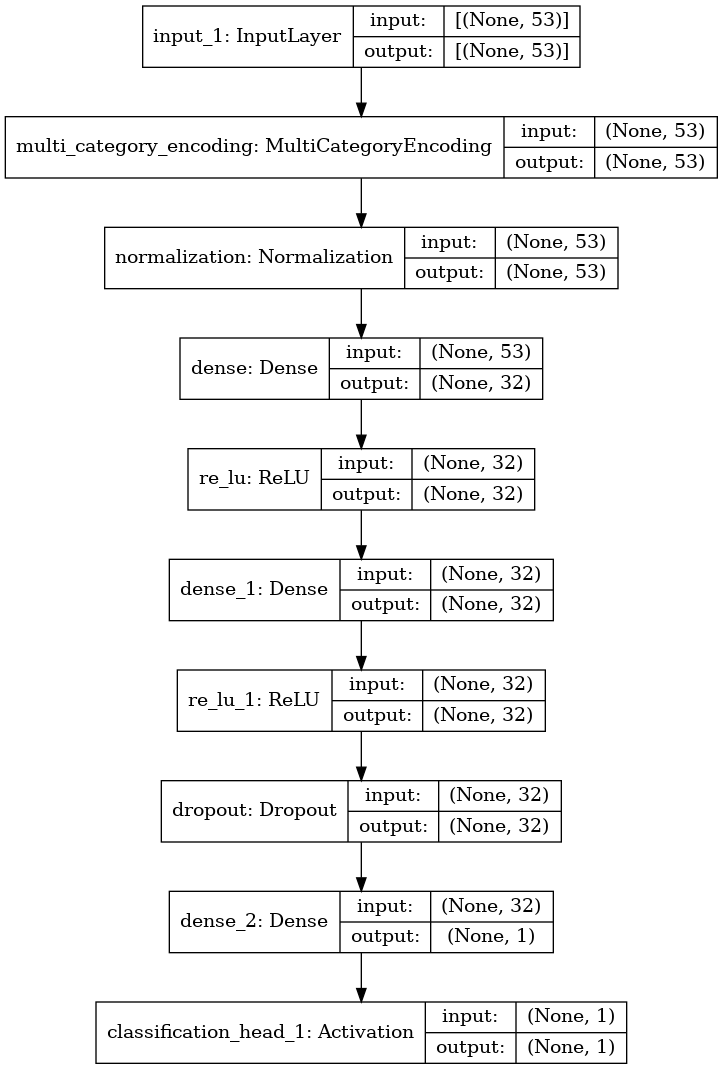

In [28]:
tf.keras.utils.plot_model(best_model, show_shapes = True, expand_nested = True) 

## Salvando o melhor Modelo

In [29]:
try:
    best_model.save("final_model", save_format="tf")
except Exception:
    best_model.save("final_model.h5")

INFO:tensorflow:Assets written to: final_model/assets


## Análise das Tentativas

In [30]:
def printResults(path = 'ak_classifiers'):
    trial_json = os.popen('ls ./{}/trial_*/trial.json'.format(path)).read().split('\n')[:-1]
    DATA = []
    
    for file in trial_json:
        with open(file) as f: 
            DATA.append(json.load(f))

    for k in range(len(DATA)):
        DATA[k]['hyperparameters']['values']['score'] = DATA[k]['score']
    
    hyper_df = pd.concat([pd.DataFrame.from_dict(data['hyperparameters']['values'], orient = 'index') for data in DATA], axis=1)
    hyper_df.columns = ["trial#{}".format(k+1) for k in range(len(DATA))]
    
    best_index = int(str(hyper_df.loc['score'].sort_values(ascending=False)).split('#')[1].split(' ')[0])-1
    best = DATA[best_index]
    return (hyper_df, best, best['trial_id'])

In [31]:
results_df, best, trial_id = printResults()
results_df

,trial#1,trial#2,trial#3,trial#4,trial#5,trial#6,trial#7,trial#8,trial#9,trial#10,...,trial#27,trial#28,trial#29,trial#30,trial#31,trial#32,trial#33,trial#34,trial#35,trial#36
structured_data_block_1/normalize,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
structured_data_block_1/dense_block_1/use_batchnorm,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
structured_data_block_1/dense_block_1/num_layers,2,2,2,2,2,2,2,2,2,3,...,2,2,2,2,2,2,2,2,2,2
structured_data_block_1/dense_block_1/units_0,16,16,32,32,32,1024,256,32,32,128,...,32,512,32,32,32,32,32,32,32,256
structured_data_block_1/dense_block_1/dropout,0,0,0.25,0,0,0,0,0.50,0,0.00,...,0,0,0,0,0,0,0,0,0,0.50
structured_data_block_1/dense_block_1/units_1,32,32,32,32,32,32,32,32,32,512,...,32,32,32,512,32,32,16,32,32,512
classification_head_1/dropout,0.00,0.00,0.25,0.25,0.50,0.25,0.25,0.25,0.25,0.00,...,0.00,0.25,0.25,0.25,0.50,0.00,0.25,0.25,0.25,0.25
optimizer,adam,adam,adam,adam,adam,adam,adam,adam,adam,adam,...,adam,adam,adam,adam,adam,adam,adam,adam,adam,adam
learning_rate,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
score,0.79,0.79,0.76,0.80,0.77,0.77,0.80,0.75,0.81,0.78,...,0.76,0.80,0.70,0.80,0.78,0.79,0.79,0.79,0.63,0.70


# Classificadores

In [35]:
classifiers_results = pd.DataFrame(columns=['Model', 'Acc','Prec', 'Rec', 'F1', 'ROC'])
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train.values.ravel())
    y_test_pred_clf = clf.predict(X_test)
    
    res = {
        'Model': clf_name,
        'Acc': accuracy_score(y_test, y_test_pred_clf),
        'ROC': roc_auc_score(y_test, y_test_pred_clf),
        'Prec': precision_score(y_test, y_test_pred_clf),
        'Rec': recall_score(y_test, y_test_pred_clf),
        'F1': f1_score(y_test, y_test_pred_clf),
    }
    
    classifiers_results = classifiers_results.append(res, ignore_index=True)

    # Normalized
    clf.fit(nX_train, y_train.values.ravel())
    y_test_pred_clf = clf.predict(nX_test)
    nres = {
        'Model': clf_name + " (normalized)",
        'Acc': accuracy_score(y_test, y_test_pred_clf),
        'ROC': roc_auc_score(y_test, y_test_pred_clf),
        'Prec': precision_score(y_test, y_test_pred_clf),
        'Rec': recall_score(y_test, y_test_pred_clf),
        'F1': f1_score(y_test, y_test_pred_clf),
    }
    
    classifiers_results = classifiers_results.append(nres, ignore_index=True)
    
# Add AutoKeras Best Model to comparison
ak_model = load_model("ak_best_model", custom_objects=ak.CUSTOM_OBJECTS)
predictions = ak_model.predict(X_test)
y_test_pred_ak = np.array([])
for prob in predictions:
    if prob >= 0.5:
        y_test_pred_ak = np.append(y_test_pred_ak, [1])
    else:
        y_test_pred_ak = np.append(y_test_pred_ak, [0])

res = {
    'Model': "AK Model",
    'Acc': accuracy_score(y_test, y_test_pred_ak),
    'Prec': precision_score(y_test, y_test_pred_ak),
    'Rec': recall_score(y_test, y_test_pred_ak),
    'F1': f1_score(y_test, y_test_pred_ak),
    'ROC': roc_auc_score(y_test, y_test_pred_ak),
}

classifiers_results = classifiers_results.append(res, ignore_index=True)
classifiers_results.sort_values(by='Acc', ascending=False).reset_index(drop=True)

/home/llopes/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Acc,Prec,Rec,F1,ROC
0,AK Model,0.83,0.83,0.95,0.89,0.75
1,RandomForest,0.80,0.83,0.91,0.86,0.73
2,SVC (normalized),0.79,0.85,0.86,0.85,0.74
3,RandomForest (normalized),0.78,0.81,0.91,0.85,0.69
4,MLP (normalized),0.77,0.85,0.82,0.83,0.73
5,GaussianNaiveBayes,0.71,0.86,0.70,0.77,0.72
6,MLP,0.70,0.80,0.77,0.78,0.65
7,GaussianNaiveBayes (normalized),0.69,0.85,0.69,0.76,0.70
8,SVC,0.69,0.71,0.96,0.81,0.50
9,DecisionTree,0.68,0.79,0.74,0.77,0.64


O _'AK Model'_ apresentou os melhores resultados em termos gerais. Na prática, normalmente o objetivo está associado a uma função (heurística) que guia a solução do problema e, consequentemente, a escolha do modelo. Neste exemplo, desconsideramos a matriz de custos indicada e os resultados foram ordenados considerando a acurácia como métrica.

## _Threshold_ e Função Objetivo

Outra forma de melhor ajustar o uso do classificador é observando seu desempenho para uma métrica desejada conforme seu limiar (_threshold_). Isso pode impactar bastante o comportamento, como podemos observar (neste caso) para a métrica de precisão!

In [36]:
classifiers_results = pd.DataFrame(columns=['Threshold', 'Acc', 'AUC', 'Prec', 'Rec', 'F1'])
predictions = ak_model.predict(X_test)

for x in range(50,100,5):
    y_test_pred_ak = np.array([])
    
    for prob in predictions:
        if prob >= x/100:
            y_test_pred_ak = np.append(y_test_pred_ak, [1])
        else:
            y_test_pred_ak = np.append(y_test_pred_ak, [0])

    res = {
        'Threshold': x/100,
        'Acc': accuracy_score(y_test, y_test_pred_ak),
        'AUC': roc_auc_score(y_test, y_test_pred_ak),
        'Prec': precision_score(y_test, y_test_pred_ak),
        'Rec': recall_score(y_test, y_test_pred_ak),
        'F1': f1_score(y_test, y_test_pred_ak)
    }

    classifiers_results = classifiers_results.append(res, ignore_index=True)
classifiers_results.sort_values(by='Acc', ascending=False).reset_index(drop=True)

,Threshold,Acc,AUC,Prec,Rec,F1
0,0.50,0.83,0.75,0.83,0.95,0.89
1,0.55,0.81,0.74,0.83,0.91,0.87
2,0.60,0.79,0.74,0.84,0.87,0.85
3,0.65,0.75,0.72,0.85,0.79,0.82
4,0.70,0.71,0.70,0.84,0.73,0.78
5,0.75,0.68,0.70,0.86,0.65,0.74
6,0.80,0.64,0.69,0.88,0.57,0.69
7,0.85,0.60,0.67,0.89,0.50,0.64
8,0.90,0.53,0.65,0.93,0.36,0.52
9,0.95,0.40,0.56,0.92,0.16,0.27


# Notas

## Importância de Atributos

Podemos observar, quanto às características analisadas de forma personalizada, sua contribuição para o classificador _RandomForest_.

- numerical_features   = ['attr_2', 'attr_5', 'attr_8', 'attr_11', 'attr_13', 'attr_16', 'attr_18']
- **personal_features = ['attr_7', 'attr_9']**
- le_features = ['attr_19', 'attr_20']
- ohe_features = ['attr_1', 'attr_3', 'attr_4', 'attr_6', 'attr_10', 'attr_12', 'attr_14', 'attr_15', 'attr_17']

In [37]:
rfc = RandomForestClassifier()
rf = rfc.fit(X_train, y_train.values.ravel())

feature_importance = pd.DataFrame()
feature_importance["Feature"] = X_train.columns
feature_importance["Importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("Importance", ascending=False).reset_index(drop=True)
feature_importance

,Feature,Importance
0,attr_5,0.09
1,attr_2,0.08
2,attr_13,0.07
3,attr_1-3,0.05
4,attr_1-0,0.05
5,attr_7,0.04
6,attr_11,0.03
7,attr_3-4,0.03
8,attr_6-0,0.03
9,attr_8,0.03


## Comparação com dados estruturados apenas com _OHE_

### Reiniciando todos os dados e aplicando _OHE_

In [38]:
processed_data = df.copy()

ohe_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_features = ['attr_1', 'attr_3', 'attr_4', 'attr_6', 'attr_7', 'attr_9', 'attr_10', 'attr_12', 'attr_14', 'attr_15', 'attr_17', 'attr_19', 'attr_20']
for cf in categorical_features:
    enc_df = pd.DataFrame(ohe_encoder.fit_transform(processed_data[[cf]]).toarray())
    enc_df = enc_df.add_prefix(cf + '-')
    processed_data = processed_data.join(enc_df)
    processed_data.pop(cf)
    
processed_data['Class'] = processed_data.pop("Class")
processed_data

,attr_2,attr_5,attr_8,attr_11,attr_13,attr_16,attr_18,attr_1-0,attr_1-1,attr_1-2,...,attr_15-2,attr_17-0,attr_17-1,attr_17-2,attr_17-3,attr_19-0,attr_19-1,attr_20-0,attr_20-1,Class
0,6,1169,4,4,67,2,1,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1
1,48,5951,2,2,22,1,1,0.00,1.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0
2,12,2096,2,3,49,1,2,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1
3,42,7882,2,4,45,1,2,1.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1
4,24,4870,3,4,53,2,2,1.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1
996,30,3857,4,4,40,1,1,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1
997,12,804,4,4,38,1,1,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1
998,45,1845,4,4,23,1,1,1.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0


### Recalcuclando conjuntos de Treinamento e Teste

In [39]:
data   = processed_data.loc[:, processed_data.columns != 'Class']
target = processed_data.loc[:, processed_data.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

### Avaliando os dados conforme o classificador RandomForest

In [40]:
rfc = RandomForestClassifier()
rf = rfc.fit(X_train, y_train.values.ravel())

feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False).reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance)

      feature  importance
0      attr_5        0.10
1     attr_13        0.08
2      attr_2        0.07
3    attr_1-3        0.05
4    attr_1-0        0.04
5     attr_11        0.04
6      attr_8        0.03
7    attr_3-4        0.02
8    attr_4-0        0.02
9     attr_16        0.02
10   attr_6-0        0.02
11   attr_9-1        0.02
12  attr_15-1        0.02
13  attr_12-2        0.02
14   attr_4-4        0.02
15   attr_7-1        0.02
16   attr_9-2        0.02
17   attr_3-2        0.02
18  attr_12-0        0.01
19  attr_14-2        0.01
20   attr_1-1        0.01
21  attr_19-0        0.01
22   attr_7-2        0.01
23  attr_14-0        0.01
24  attr_17-2        0.01
25  attr_19-1        0.01
26   attr_7-4        0.01
27   attr_6-4        0.01
28  attr_12-1        0.01
29   attr_3-0        0.01
30   attr_4-3        0.01
31  attr_17-3        0.01
32  attr_15-0        0.01
33   attr_7-3        0.01
34  attr_12-3        0.01
35   attr_3-1        0.01
36  attr_10-0        0.01
37   attr_7-

Observe como os atributos 7 e 9 aparecem em uma posição melhor no ranking de importância quando manipulados com o tratamento de dados personalizado (_ranking_ 5 _vs_ 20 para o atributo 7; e _ranking_ 10 _vs_ 16 para o atributo 9).

---
# Respostas

**c. Faça um resumo dos resultados, conclusões e recomendações a partir da sua análise.**\
Conforme observado nos experimentos, o AutoKeras foi capaz de gerar o melhor modelo a ser utilizado no problema proposto. O resultado é satisfatório com acurácia em 83%. Claro, uma métrica específica não foi apontada mas ainda assim, em termos gerais, as demais métricas apresentaram um bom valor de referência.  Minhas recomendações se complentam nas respostas a seguir mas, de início, eu conversaria com a área de negócios ou responsáveis para definir um modo de operação e entender melhor sobre a aprovação. É importante estar bem claro quais os tipos de erros que podem acontecer (bem como sua probabilidades). Na prática, parece menos grave não liberar o crédito para um cliente que poderia o ter do que permitir crédito a um cliente incapaz de cumprir as condições de pagamento. Esses termos podem devem ser verificados e definidos já que irão impactar na experiência final. Uma vez que isso for considerado é possível apresentar números mais diretos e decidir se o modelo atende (ou não) o comportamento desejado.

\
**d. Quais os próximos passos que você sugere para atingir o objetivo inicial de automatizar o processo decisório e escalar a operação?**\
Visando automatizar o processo decisório é preciso tornar o modelo gerado disponível para classificação. Para isso, não basta publicar o modelo final. Deve-se considerar todos os processamentos realizados nos _inputs_ para que o modelo possar inferir conforme previsto em treinamento. Isso envolve criar regras ou transformações que descartam ou mapeiam os valores brutos em valores que possam ser utilizados e interpreados pelo modelo. Valores nunca visto podem ser, inclusive, armazenados para serem considerados em treinamentos e versões futuras do modelo. Este envio e tratamento de dados acontece nos mais diversos formatos, passando desde um arquivo .csv ou .xml pelo cliente, como um acesso via API ou diretamente uma consulta à base de dados.
<br>

Isso posto, agora é necessário ter o modelo carregado em um ambiente. Esse ambiente depende das restrições aplicadas mas normalmente pode-se ter o modelo disponível em _Cloud_ dentre as diversas propostas existentes como _Amazon SageMaker_, _Google Cloud Machine Learning_, _Microsoft Azure_, por exemplo. Dessa forma, normalmente os modelos são publicados e respondem como APIs. Entretanto, este é apenas um dos modos. Podemos colocar modelos em aplicações web próprias; podemos ter modelos executando em dispositivos mais simples, seja nas pontas ou em um servidor central.

A questão de escalabilidade se faz relativamente simples: os modelos gerados são capazes de calcular as respostas em poucos segundos ou menos, a depender do problema. Para escalar, basta replicar os modelos em outras instâncias conforme a necessidade do fluxo/vazão de dados do problema.

Para o cenário proposto, podemos por exemplo incorporar os modelos em uma aplicação web que é capaz de avaliar cada cliente como apto ou não para recebimento de crédito. A análise pode ser feita a cada cadastrado, disparando ações para consulta de banco ou requisições via API, por exemplo. Ou ainda, um operador pode ter uma planilha de clientes avaliada pelo modelo, na qual será acrescida a avaliação por parte da inteligência artificial.

\
**e. Você tem sugestões para melhorar o resultado obtido?**\
Sim, bastante! Quanto aos dados, poderia-se considerar a possibilidade de conseguir novas amostras ou mesmo novas características. Além disso, outros pré-processamento de dados poderiam ser aplicados como a normalização em outro intervalo (-1, 1 ex.) bem como diferentes estratégias de aumento/redução dos dados.
<br>

Quanto aos modelos, aqui neste exemplo foram executados com seus hiper-parâmetros _default_. Muitos deles possuem uma vasta possibilidade de configurações como os kernels dos _SVM_, as quantidades de camadas e neurônio nas MLPs, etc. Também é importante mencionar que existem diversos outros tipos de técnicas e classificadores não considerados aqui. Mais que isso, é possível ainda combiná-los (_ensemble_) com diversas estratégias (_bagging_, _bosting_ ou outra de escolha própria e conforme o problema exige). Por fim, é possível ainda aplicar Algoritmos Genéticos (ou Colônia de Formigas, _PSO_, ou algum outro dos diversos algoritmos de otimização) para buscar a combinação de hiper-parâmetros para cada modelo. Como cientista de dados que entende como os modelos funcionam, é possível nortear essa busca reduzindo consideravelmente o esforço exigido pré-configurando algumas opções. 

Finalmente, com o modelo já escolhido, ainda é possível "configurar" seu modo de operação, alterando o limiar (_threshold_) para que, por exemplo, aprovemos apenas os casos em que o modelo tem mais "certeza" (isto é, apresenta maior confiança ou certeza na probabilidade estimada!)

Tudo isso, é claro, depende em parte do tempo e recursos disponíveis, e principalmente da estratégia que se deseja ter ao utilizar o modelo em um ambiente real.

---